In [1]:
from gurobipy import *

## 本研究

In [73]:
from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
import random
from random import seed
import numpy as np
from scipy.stats import multivariate_normal
class CVaR:
    def __init__(self,ship_num,stack_num,height,n_init,size,size_,beta,mean,cov,OC,zk):
        self.ship_num=ship_num
        self.stack_num=stack_num
        self.height=height
        self.n_init=n_init
        self.beta=beta
        self.size=size
        self.size_=size_
        self.mean=mean
        self.cov=cov
        self.OC=OC
        self.zk=zk
        self.O1=[i+1 for i in range(ship_num)]
        self.S=[i+1 for i in range(stack_num)]
        self.H=[i+1 for i in range(height)]
        self.P=[i+1 for i in range(ship_num)]
        self.f=stack_num*height-sum(n_init)

        # 期待値と分散共分散行列の準備
        data_1 = np.random.multivariate_normal(mean, cov, size=self.size)

        O_=np.argsort(data_1)
        O_=O_+np.ones((size,ship_num)).astype(int)
        global O
        self.O=O_.tolist()
        O=self.O

    def solve(self):
        self.model=Model("CVaR")
        # 変数の定義
        x,c,d={},{},{}
        for s in self.S:
            for h in self.H:
                for p in self.P:
                    x[s,h,p]=self.model.addVar(vtype="B",name="x_"+str(s)+"_"+str(h)+"_"+str(p))

        for s in self.S:
            for h in range(2,len(self.H)+1):
                for i,o in enumerate(self.O):
                    c[s,h,i]=self.model.addVar(vtype="c",lb=0,name="c_"+str(s)+"_"+str(h)+"_"+str(i))

        for i in range(len(self.O)):
            d[i]=self.model.addVar(vtype="C",lb=0)
        alpha=self.model.addVar(vtype="C",lb=0,name="alpha")
        u=self.model.addVar(vtype="C",lb=0,name="u")

        self.model.update()
        self.model._vars=self.model.getVars()

        for p in self.P:
            self.model.addConstr(quicksum(x[s,h,p] for s in self.S for h in self.H)==self.n_init[p-1])

        for s in self.S:
            for h in self.H:
                self.model.addConstr(quicksum(x[s,h,p] for p in self.P)<=1)

        for s in self.S:
            for h in range(1,len(self.H)):
                self.model.addConstr(quicksum(x[s,h+1,p] for p in self.P)<=quicksum(x[s,h,p] for p in self.P))

        for s in self.S:
            for h in range(2,len(self.H)+1):
                for h_ in range(1,h):
                    for i,o in enumerate(self.OC):
                        for j,p in enumerate(o):
                            self.model.addConstr(c[s,h,i]>=quicksum(x[s,h,k] for k in o[j:])-quicksum(x[s,h_,k] for k in o[j:]))

        for i in range(len(self.OC)):
            self.model.addConstr(d[i]>=quicksum(c[s,h,i] for s in self.S for h in self.H if h!=1)-alpha)

        self.model.addConstr(u>=alpha+quicksum(d[i] for i in range(len(self.O)))/((1-self.beta)*len(self.O)))
        self.model.setObjective(u)
        self.model._vars=self.model.getVars()
        self.model.params.LazyConstraints = 1
        if self.f>=self.height:
            self.model.optimize()
        else:
            print("実行不可")

    def get_result(self):
        if self.model.Status==GRB.OPTIMAL:
            EPS=1.e-6
            x,c,alpha,u=self.get_optimal_sol()
            self.result=np.zeros((self.height,self.stack_num))
            for (s,h,p) in x:
                if x[s,h,p]>EPS:
                    self.result[self.height-h][s-1]=int(p)
            self.result=self.result.astype(int)
            return self.result
    
    def get_penalty(self,result):
        self.result=result
        self.penalty=[]
        x,c,alpha,u=self.get_optimal_sol()
        for k in self.O:
            OO=k
            a=0
            for j in range(self.stack_num):
                for i in range(1,self.height):
                    for i_ in range(i+1,self.height+1):
                        if self.result[i-1][j]!=0 and self.result[i_-1][j]!=0:
                            if OO.index(self.result[i-1][j])>OO.index(self.result[i_-1][j]):
                                # print(j+1,height-i+1,O)
                                a+=1
                                # print("penalty!")
                                    # print(i,i_,j+1,O)
                                break
            self.penalty.append(a)
        self.zk=[i for i, x in enumerate(self.penalty) if x-alpha>0]
        for zk_ in self.zk:
            if not O[zk_] in self.OC:
                self.OC.append(self.O[zk_])
        return (self.zk,self.OC,self.penalty)

    def get_optimal_sol(self):
        if self.model.Status==GRB.OPTIMAL:
            x_opt={}
            c_opt={}
            for var in self.model._vars:
                if "x_" in var.VarName:
                    # print(var)
                    s=int(var.VarName.split("_")[-3])
                    h=int(var.VarName.split("_")[-2])
                    p=int(var.VarName.split("_")[-1])
                    x_opt[s,h,p]=var.X
                if "c_" in var.VarName:
                    s=int(var.VarName.split("_")[-3])
                    h=int(var.VarName.split("_")[-2])
                    i=int(var.VarName.split("_")[-1])
                    c_opt[s,h,i]=var.X
                if "alpha" in var.VarName:
                    alpha_opt=var.X
                if "u" in var.VarName:
                    u_opt=var.X
            return (x_opt,c_opt,alpha_opt,u_opt)
        else:
            return None

    def get_optimal_val(self):
        if self.model.Status==GRB.OPTIMAL:
            self.LB=self.model.ObjVal
            return self.model.ObjVal
        else:
            return None

    # def get_result(self):
    #     if self.model.Status==GRB.OPTIMAL:
    #         EPS=1.e-6
    #         self.result=np.zeros((self.height,self.stack_num))
    #         x_opt,c_opt,alpha_opt,u_opt=self.get_optimal_sol()
    #         for (s,h,p) in x_opt:
    #             if x_opt[s,h,p]>EPS:
    #                 self.result[self.height-h][s-1]=int(p)
    #         self.result=self.result.astype(int)
    #         # self.penalty=[]
            # for k in self.O:
            #     OO=k
            #     a=0
            #     for j in range(self.stack_num):
            #         for i in range(1,self.height):
            #             for i_ in range(i+1,self.height+1):
            #                 if self.result[i-1][j]!=0 and self.result[i_-1][j]!=0:
            #                     if OO.index(self.result[i-1][j])>OO.index(self.result[i_-1][j]):
            #                         # print(j+1,height-i+1,O)
            #                         a+=1
            #                         # print("penalty!")
            #                             # print(i,i_,j+1,O)
            #                         break
            #     self.penalty.append(a)
            # self.zk=[i for i, x in enumerate(self.penalty) if x-alpha_opt>0]
            # return self.result

In [100]:
class CuttingPlaneAlgorithm:
    def __init__(self,ship_num,stack_num,height,n_init,size,size_,beta,mean,cov,OC,zk):
        self.ship_num=ship_num
        self.stack_num=stack_num
        self.height=height
        self.n_init=n_init
        self.beta=beta
        self.size=size
        self.size_=size_
        self.mean=mean
        self.cov=cov
        self.OC=OC
        self.zk=zk
        self.O1=[i+1 for i in range(ship_num)]
        self.S=[i+1 for i in range(stack_num)]
        self.H=[i+1 for i in range(height)]
        self.P=[i+1 for i in range(ship_num)]
        self.f=stack_num*height-sum(n_init)

        # 期待値と分散共分散行列の準備
        data_1 = np.random.multivariate_normal(mean, cov, size=self.size)

        O_=np.argsort(data_1)
        O_=O_+np.ones((size,ship_num)).astype(int)
        global O
        self.O=O_.tolist()
        O=self.O

    def get_penalty(self,result):
        self.result=result
        self.penalty=[]
        for k in self.O:
            OO=k
            a=0
            for j in range(self.stack_num):
                for i in range(1,self.height):
                    for i_ in range(i+1,self.height+1):
                        if self.result[i-1][j]!=0 and self.result[i_-1][j]!=0:
                            if OO.index(self.result[i-1][j])>OO.index(self.result[i_-1][j]):
                                # print(j+1,height-i+1,O)
                                a+=1
                                # print("penalty!")
                                    # print(i,i_,j+1,O)
                                break
            self.penalty.append(a)
        self.zk=[i for i, x in enumerate(self.penalty) if x-self.alpha>0]
        for zk_ in self.zk:
            if not O[zk_] in self.OC:
                self.OC.append(self.O[zk_])
        return (self.zk,self.OC,self.penalty)

    def solve(self):
        init_result=CVaR(self.ship_num,self.stack_num,self.height,self.n_init,self.size,self.size_,self.beta,self.mean,self.cov,self.OC,self.zk)
        init_result.solve()
        result=init_result.get_result()
        LB=init_result.get_optimal_val()
        a,b,self.alpha,c=init_result.get_optimal_sol()

        def add_cutting_plane(model,where):
            if where == GRB.callback.MIPSOL:
                c_var,x_var,x_tmp={},{},{}
                for var in self.model._vars:
                    if "u" in var.VarName:
                        u_var=var
                    if "alpha" in var.VarName:
                        alpha_var=var
                    if "c_" in var.VarName:
                        s=int(var.VarName.split("_")[-3])
                        h=int(var.VarName.split("_")[-2])
                        i=int(var.VarName.split("_")[-1])
                        c_var[s,h,i]=var
                    if "x_" in var.VarName:
                        s=int(var.VarName.split("_")[-3])
                        h=int(var.VarName.split("_")[-2])
                        p=int(var.VarName.split("_")[-1])
                        x_var[s,h,p]=var
                        x_tmp[s,h,p]=model.cbGetSolution(var)
                result=self.get_result(x_tmp)
                print(result)
                zk,OC,penalty=self.get_penalty(result)
                print(len(zk),len(OC))
                for s in self.S:
                    for h in range(2,len(self.H)+1):
                        for h_ in range(1,h):
                            for i,o in enumerate(OC):
                                for j,p in enumerate(o):
                                    model.cbLazy(c[s,h,i]>=quicksum(x[s,h,k] for k in o[j:])-quicksum(x[s,h_,k] for k in o[j:]))
                model.cbLazy(u_var>=alpha_var+quicksum(quicksum(c_var[s,h,i] for s in self.S for h in self.H if h!=1)-alpha_var for i in zk)/((1-self.beta)*len(O)))
        self.model=Model("CuttingPlaneCVaRMinimization")
        x,c,d={},{},{}
        for s in self.S:
            for h in self.H:
                for p in self.P:
                    x[s,h,p]=self.model.addVar(vtype="B",name="x_"+str(s)+"_"+str(h)+"_"+str(p))

        for s in self.S:
            for h in range(2,len(self.H)+1):
                for i,o in enumerate(self.O):
                    c[s,h,i]=self.model.addVar(vtype="c",lb=0,name="c_"+str(s)+"_"+str(h)+"_"+str(i))

        for i in range(len(self.O)):
            d[i]=self.model.addVar(vtype="C",lb=0)
        alpha=self.model.addVar(vtype="C",lb=0,name="alpha")
        u=self.model.addVar(vtype="C",lb=0,name="u")

        self.model.update()
        self.model._vars=self.model.getVars()

        for p in self.P:
            self.model.addConstr(quicksum(x[s,h,p] for s in self.S for h in self.H)==self.n_init[p-1])

        for s in self.S:
            for h in self.H:
                self.model.addConstr(quicksum(x[s,h,p] for p in self.P)<=1)

        for s in self.S:
            for h in range(1,len(self.H)):
                self.model.addConstr(quicksum(x[s,h+1,p] for p in self.P)<=quicksum(x[s,h,p] for p in self.P))

        for s in self.S:
            for h in range(2,len(self.H)+1):
                for h_ in range(1,h):
                    for i,o in enumerate(self.OC):
                        for j,p in enumerate(o):
                            self.model.addConstr(c[s,h,i]>=quicksum(x[s,h,k] for k in o[j:])-quicksum(x[s,h_,k] for k in o[j:]))

        for i in range(len(self.OC)):
            self.model.addConstr(d[i]>=quicksum(c[s,h,i] for s in self.S for h in self.H if h!=1)-alpha)

        self.model.addConstr(u>=alpha+quicksum(d[i] for i in range(len(self.O)))/((1-self.beta)*len(self.O)))
        self.model.setObjective(u)
        self.model._vars=self.model.getVars()
        self.model.params.LazyConstraints = 1
        if self.f>=self.height:
            self.model.optimize(add_cutting_plane)
            result=self.get_result()
        else:
            print("実行不可")

    def get_optimal_val(self):
        if self.model.Status==GRB.OPTIMAL:
            self.LB=self.model.ObjVal
            return self.model.ObjVal
        else:
            return None

    def get_optimal_sol(self):
        if self.model.Status==GRB.OPTIMAL:
            x_opt={}
            c_opt={}
            for var in self.model._vars:
                if "x_" in var.VarName:
                    # print(var)
                    s=int(var.VarName.split("_")[-3])
                    h=int(var.VarName.split("_")[-2])
                    p=int(var.VarName.split("_")[-1])
                    x_opt[s,h,p]=var.X
                if "c_" in var.VarName:
                    s=int(var.VarName.split("_")[-3])
                    h=int(var.VarName.split("_")[-2])
                    i=int(var.VarName.split("_")[-1])
                    c_opt[s,h,i]=var.X
                if "alpha" in var.VarName:
                    alpha_opt=var.X
                if "u" in var.VarName:
                    u_opt=var.X
            return (x_opt,c_opt,alpha_opt,u_opt)
        else:
            return None

    def get_result(self,x_tmp):
        self.x_tmp=x_tmp
        EPS=1.e-6
        self.result=np.zeros((self.height,self.stack_num))
        for (s,h,p) in self.x_tmp:
            if self.x_tmp[s,h,p]>EPS:
                self.result[self.height-h][s-1]=int(p)
        self.result=self.result.astype(int)
        return self.result
    
    # def get_penalty(self,result):
    #     if self.model.Status==GRB.OPTIMAL:
    #         self.result=result
    #         self.penalty=[]
    #         x,c,alpha,u=self.get_optimal_sol()
    #         for k in self.O:
    #             OO=k
    #             a=0
    #             for j in range(self.stack_num):
    #                 for i in range(1,self.height):
    #                     for i_ in range(i+1,self.height+1):
    #                         if self.result[i-1][j]!=0 and self.result[i_-1][j]!=0:
    #                             if OO.index(self.result[i-1][j])>OO.index(self.result[i_-1][j]):
    #                                 # print(j+1,height-i+1,O)
    #                                 a+=1
    #                                 # print("penalty!")
    #                                     # print(i,i_,j+1,O)
    #                                 break
    #             self.penalty.append(a)
    #         self.zk=[i for i, x in enumerate(self.penalty) if x-alpha>0]
    #         for zk_ in self.zk:
    #             self.OC.append(self.O[zk_])
    #         return (self.zk,self.OC,self.penalty)

In [101]:
size=100
size_=100
beta=0.75
inst=[4,4,[2,2,1,1,3,3]]
pcvar=[]
import numpy as np
# mean=np.arange(1,ship_num+1)
mean=np.arange(1,len(inst[2])+1)
covl=[1 for i in range(len(inst[2]))]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((len(inst[2]),len(inst[2])))
for i in range(len(inst[2])):
    for j in range(len(inst[2])):
        if i==j:
            cov[i][i]=covl[1]
for i in range(len(inst[2])):
    for j in range(len(inst[2])):
        if i!=j:
            cov[i][j]=0


OC=[]
EPS=0.1
a=0
UB=1000
LB=0
UB_k=[]
zk=[]
# while UB-LB>=EPS:
#     print("UB=",UB)
#     print("LB=",LB)
#     print("UB-LB=",UB-LB)
#     print("LEN=",len(OC))
#     model=CuttingPlaneAlgorithm(len(inst[2]),inst[0],inst[1],inst[2],size,size_,beta,mean,cov,OC,zk)
#     zk,OC,penalty=model.solve()
#     n=0
#     while n<beta*size:
#         n+=1
#     tau=n
#     N_sigma=np.sort(penalty)
#     alpha_=N_sigma[tau-1]

#     UB=((tau/size-beta)*alpha_+sum(N_sigma[tau:]))/((1-beta)*size)
#     UB_k.append(UB)
#     UB=min(UB_k)
#     # for b in zk:
#     #     if not O[b] in OC:
#     #         OC.append(O[b])
#     a+=1
#     # print(OC)
# print("finish!!")
model=CuttingPlaneAlgorithm(len(inst[2]),inst[0],inst[1],inst[2],100,100,0.75,mean,cov,OC,[])
model.solve()

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 35 rows, 1398 columns and 438 nonzeros
Model fingerprint: 0xdd9f839d
Variable types: 1302 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 35 rows, 1398 

KeyError: (1, 2, 100)

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_16396\3372821603.py", line 87, in add_cutting_plane
KeyError: (1, 2, 100)


H    0     0                       0.7173913    0.00000   100%     -    1s
     0     0    0.00000    0   10    0.71739    0.00000   100%     -    2s
     0     2    0.00000    0   10    0.71739    0.00000   100%     -    2s
[[0 2 0 0]
 [1 2 4 0]
 [1 5 6 3]
 [5 5 6 6]]
21 111


KeyError: (1, 2, 100)

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_16396\3372821603.py", line 87, in add_cutting_plane
KeyError: (1, 2, 100)


*   13    14               4       0.1521739    0.00000   100%   178    2s
[[0 1 0 1]
 [0 3 2 5]
 [0 6 2 5]
 [4 6 6 5]]
9 113


KeyError: (1, 2, 100)

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_16396\3372821603.py", line 87, in add_cutting_plane
KeyError: (1, 2, 100)


H   27    18                       0.1147541    0.00000   100%   168    3s
[[3 1 0 0]
 [6 5 0 0]
 [6 5 1 2]
 [6 5 4 2]]
4 113


KeyError: (1, 2, 100)

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_16396\3372821603.py", line 87, in add_cutting_plane
KeyError: (1, 2, 100)


*   39    27               9       0.0217391    0.00000   100%   149    3s
[[0 2 0 1]
 [0 2 0 5]
 [3 6 1 5]
 [6 6 4 5]]
4 113


KeyError: (1, 2, 100)

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\daiki\AppData\Local\Temp\ipykernel_16396\3372821603.py", line 87, in add_cutting_plane
KeyError: (1, 2, 100)


H   61    31                       0.0217391    0.00000   100%   111    4s
   120    34     cutoff   11         0.02174    0.00000   100%  86.0    5s

Cutting planes:
  Lazy constraints: 12891

Explored 527 nodes (38471 simplex iterations) in 9.97 seconds (7.52 work units)
Thread count was 8 (of 8 available processors)

Solution count 5: 0.0217391 0.0217391 0.114754 ... 0.717391

Optimal solution found (tolerance 1.00e-04)
Best objective 2.173911225972e-02, best bound 2.173911225972e-02, gap 0.0000%

User-callback calls 1447, time in user-callback 1.74 sec


TypeError: get_result() missing 1 required positional argument: 'x_tmp'

In [54]:
b=model.get_optimal_val()
print(b)
result=model.get_result()

0.0


In [55]:
print(result)
zk,OC,p=model.get_penalty(result)
print(p)

[[0 0 0 0]
 [6 5 2 1]
 [6 5 3 1]
 [6 5 4 2]]
[1, 3, 2, 3, 1, 0, 1, 2, 0, 0, 3, 0, 0, 1, 0, 2, 1, 3, 0, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 1, 3, 1, 1, 0, 1, 3, 3, 1, 1, 1, 0, 2, 1, 0, 1, 0, 0, 2, 1, 2, 3, 1, 2, 1, 2, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 0, 0, 2, 2, 0, 3, 0, 1, 1, 0, 0, 2, 1, 0, 1, 0, 1, 3, 0]


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 32 rows, 48 columns and 159 nonzeros
Model fingerprint: 0xdf3425ed
Variable types: 0 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 5.0000000
Presolve removed 0 rows and 3 columns
Presolve time: 0.00s
Presolved: 32 rows, 45 columns, 150 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)
Found heuristic solution: objective 1.0000000

Root relaxation: objective 0.000000e+00, 17 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Ex

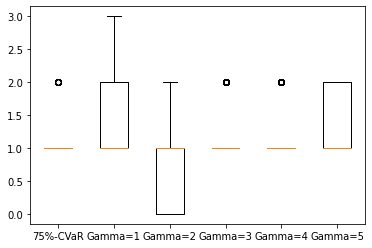

In [87]:
data_2 = np.random.multivariate_normal(mean, cov, size=size_)

OR_=np.argsort(data_2)
OR_=OR_+np.ones((size_,len(inst[2]))).astype(int)
OR=OR_.tolist()
penalty_cvar=[]
for k in OR:
    OR2=k
    a=0
    for j in range(inst[0]):
        for i in range(1,inst[1]):
            for i_ in range(i+1,inst[1]+1):
                if result[i-1][j]!=0 and result[i_-1][j]!=0:
                    if OR2.index(result[i-1][j])>OR2.index(result[i_-1][j]):
                        # print(j+1,height-i+1,O)
                        a+=1
                        # print("penalty!")
                            # print(i,i_,j+1,O)
                        break
    penalty_cvar.append(a)
penalty_cvar=np.sort(penalty_cvar)
penalty_cvar=penalty_cvar[round(0.75*size_):]
pcvar=[]
pcvar+=list(penalty_cvar)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size_,mean,cov)
  prob+=list(penalty_r)
#   print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()
# plt.hist(penalty_cvar,bins=50)
# plt.show()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 32 rows, 48 columns and 159 nonzeros
Model fingerprint: 0xdf3425ed
Variable types: 0 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 5.0000000
Presolve removed 0 rows and 3 columns
Presolve time: 0.00s
Presolved: 32 rows, 45 columns, 150 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)
Found heuristic solution: objective 1.0000000

Root relaxation: objective 0.000000e+00, 17 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Ex

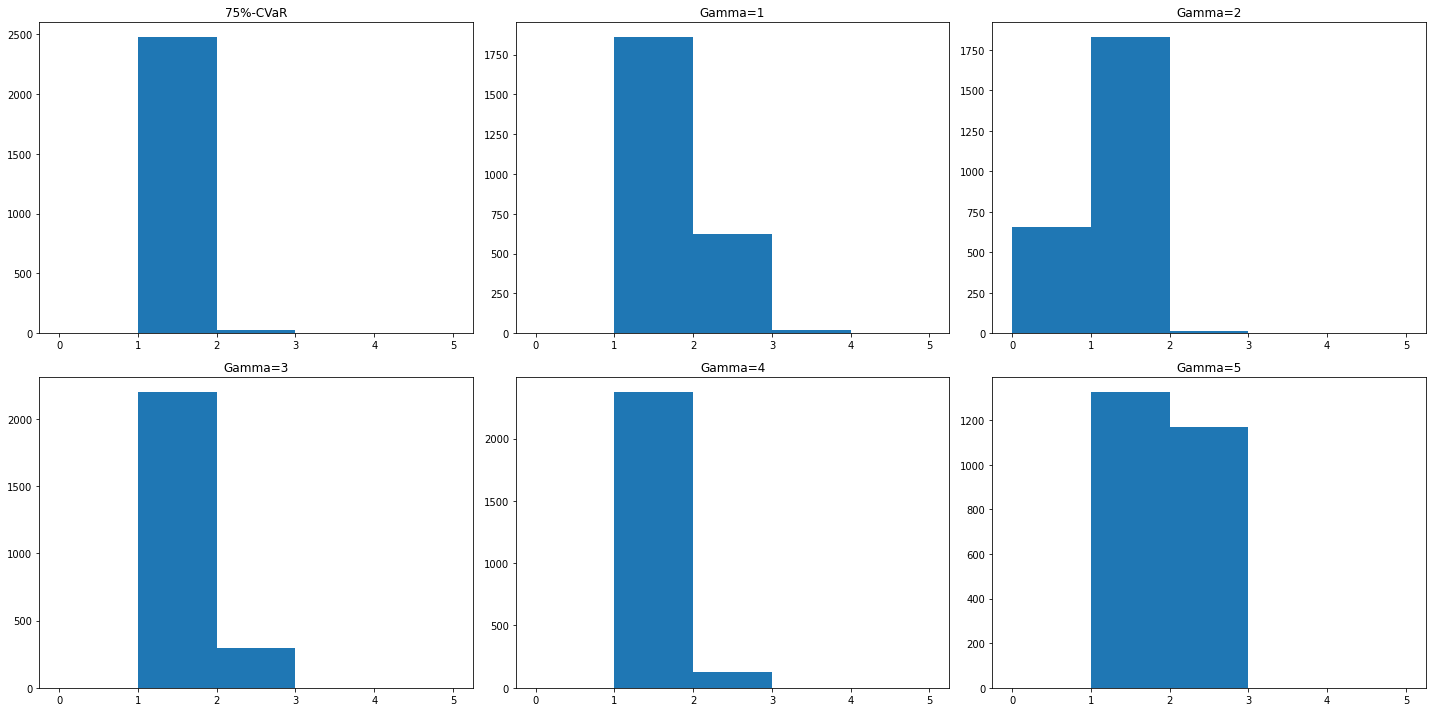

len= 2500


In [88]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,3,figsize=(20,10),tight_layout=True)
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size_,mean,cov)
  prob+=list(penalty_r)
  # print(prob)
  # data+=(tuple(prob),)
  # l.append("Gamma="+str(g))
  # print("data=",data)
# plt.boxplot(data,labels=l)
# plt.show()

  ax[int(g/3)][g%3].hist(prob,bins=5,range=(0,5))
  ax[int(g/3)][g%3].set_title("Gamma="+str(g))
ax[0][0].hist(penalty_cvar,bins=5,range=(0,5))
ax[0][0].set_title("75%-CVaR")
plt.show()
print("len=",len(prob))

In [89]:
print(result)

[[0 0 0]
 [0 4 1]
 [2 5 3]
 [6 8 7]]
